# CAPSTONE PROJECT: MULTI-CLASS MENTAL HEALTH CLASSIFICATION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
import os
import random
import tensorflow as tf

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

2025-09-22 06:00:25.786737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758520825.808629      90 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758520825.815231      90 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## CELL 2: SET RANDOM SEEDS
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# --- NLTK Setup ---
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# DATA LOADING, EXPLORATION, AND PREPROCESSING

In [4]:
filepath = "/kaggle/input/mental-health/Combined Data.csv"
df = pd.read_csv(filepath)
df.dropna(inplace=True)
df.drop_duplicates(subset=['statement'], inplace=True)
df.drop(columns=['Unnamed: 0'],inplace = True)
print(f"Data loaded. Full size: {len(df)} rows.")

Data loaded. Full size: 51073 rows.



--- Visualizing Class Distribution ---


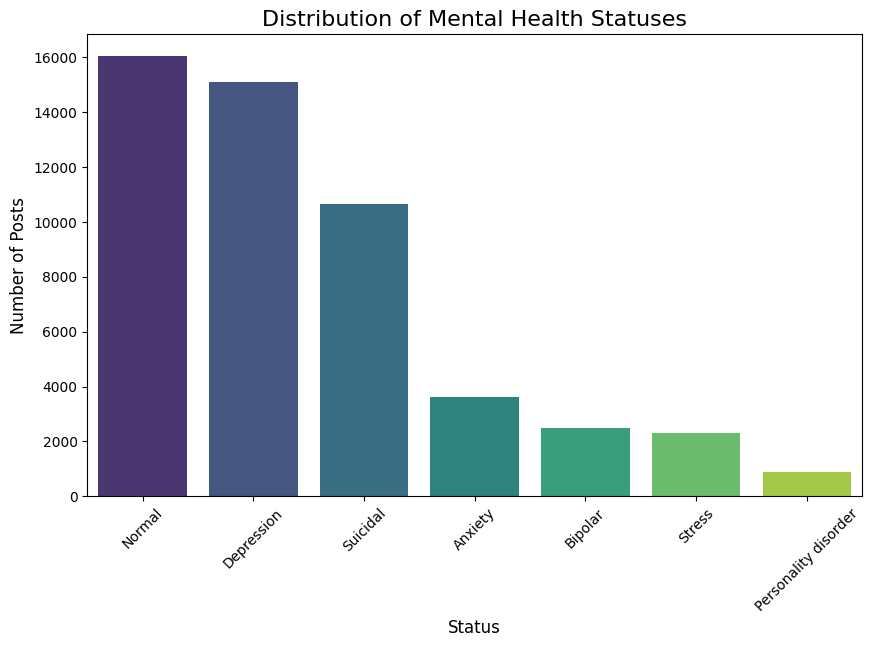

In [5]:
print("\n--- Visualizing Class Distribution ---")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, 
              palette='viridis')
plt.title('Distribution of Mental Health Statuses', fontsize=16)
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [8]:
print(df['status'].value_counts())

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64


In [9]:
df = df.groupby('status').sample(n=800, random_state=42)
df

,statement,status
34234,Fear of getting schizophrenia or any mental il...,Anxiety
34691,My mind is tricking me into feeling like I nee...,Anxiety
35451,Dont know whats wrong with me I really can't b...,Anxiety
51950,A reminder that progress isn't linear and that...,Anxiety
52587,Just had one of the worst anxiety attacks of m...,Anxiety
...,...,...
26732,My mental health has declined drastically in t...,Suicidal
9220,She says it when she is angry and I can tell s...,Suicidal
12744,So in the last several months I have had 3 fai...,Suicidal
18226,please no sympathy I am lost and suicide seems...,Suicidal



--- Visualizing Class Distribution ---


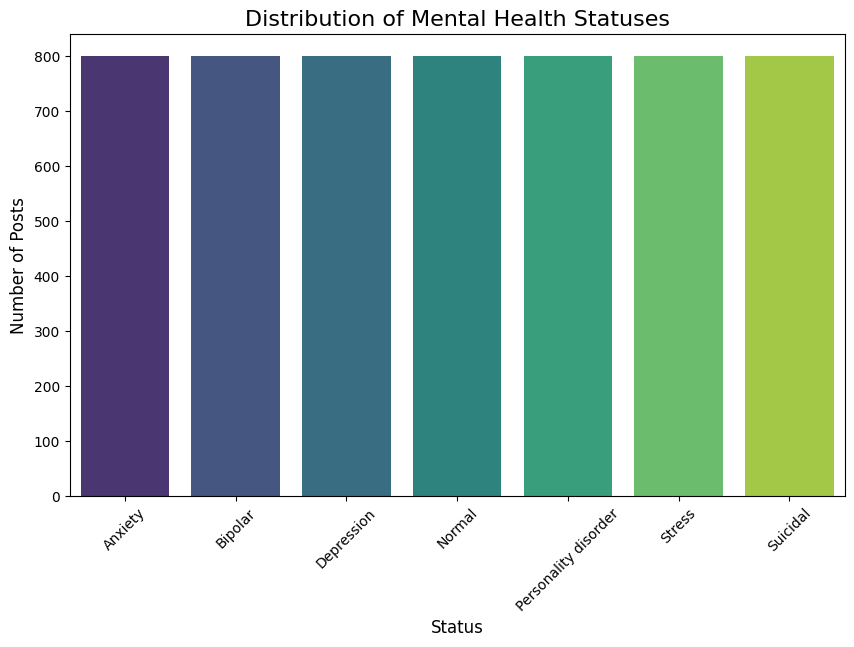

In [10]:
print("\n--- Visualizing Class Distribution ---")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, 
              palette='viridis')
plt.title('Distribution of Mental Health Statuses', fontsize=16)
plt.ylabel('Number of Posts', fontsize=12)
plt.xlabel('Status', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [11]:
print(f"Data has been sampled down to a balanced dataset of {len(df)} rows.")
print("\nNew class distribution:")

# This will now show 800 for every category.
print(df['status'].value_counts())

Data has been sampled down to a balanced dataset of 5600 rows.

New class distribution:
status
Anxiety                 800
Bipolar                 800
Depression              800
Normal                  800
Personality disorder    800
Stress                  800
Suicidal                800
Name: count, dtype: int64


In [12]:
# PREPROCESSING FUNCTION
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it's": "it is", "let's": "let us", "mustn't": "must not",
    "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is",
    "shouldn't": "should not", "that's": "that is", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have", "we'd": "we would",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what're": "what are", "what's": "what is", "what've": "what have", "where's": "where is",
    "who'd": "who would", "who'll": "who will", "who're": "who are", "who's": "who is",
    "who've": "who have", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}


def preprocess_text(text):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)

    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(cleaned_tokens)

test_sentence = df['statement'].iloc[7] # A random sample from your data
print(f"Original Text: \n{test_sentence}")

cleaned_sentence = preprocess_text(test_sentence)
print(f"\nCleaned Text: \n{cleaned_sentence}")

Original Text: 
Worried about it blood clots I’m worried about getting blood clots bc some days I only get around 300 steps in. At most 2-3k. My doctors said I’m fine but it’s hard to believe that.

Cleaned Text: 
worried blood clot worried getting blood clot day get around step doctor said fine hard believe


In [13]:
#APPLYING THE FUNCTION
df['cleaned_statement'] = df['statement'].apply(preprocess_text)

print("Text preprocessing complete.")
print("Here's a sample of the cleaned data:")
print(df[['status', 'cleaned_statement']].sample(5))

Text preprocessing complete.
Here's a sample of the cleaned data:
           status                                  cleaned_statement
48915      Stress  think middle nervous breakdown ive never one t...
48499      Stress  stressed money shit decision money barely enou...
14108  Depression  one simple post alone feeling really low like ...
37279      Normal                               loved chelsea lately
44643      Normal                          missed good oppertunities


In [14]:
X = df['cleaned_statement']
y = df['status']
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)
print(f"Data is ready. Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Data is ready. Training set size: 4480, Test set size: 1120


# Baseline models

In [15]:
print("1. Training Logistic Regression")
log_reg = LogisticRegression(random_state = 42, max_iter = 1000)

pipeline_lr = Pipeline([
    ('tfidf',TfidfVectorizer(max_features = 5000)),
    ('classifier',log_reg)
])

pipeline_lr.fit(X_train, y_train)

1. Training Logistic Regression


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [16]:
y_pred_lr = pipeline_lr.predict(X_test)
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr, zero_division =0))


Classification Report for Logistic Regression:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.78       160
             Bipolar       0.85      0.70      0.77       160
          Depression       0.55      0.51      0.53       160
              Normal       0.66      0.91      0.76       160
Personality disorder       0.75      0.73      0.74       160
              Stress       0.65      0.59      0.62       160
            Suicidal       0.64      0.66      0.65       160

            accuracy                           0.69      1120
           macro avg       0.70      0.69      0.69      1120
        weighted avg       0.70      0.69      0.69      1120



In [17]:
print("2. Training Multinomial Naive Bayes")
pipeline_nb= Pipeline([
    ('tfidf',TfidfVectorizer(max_features = 5000)),
    ('classifier',MultinomialNB())
])
pipeline_nb.fit(X_train, y_train)

2. Training Multinomial Naive Bayes


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', MultinomialNB())])

In [18]:
y_pred_nb = pipeline_nb.predict(X_test)
print("\Classification Report for Multinomial Naive Bayes:")
print(classification_report(y_test, y_pred_nb, zero_division = 0))

\Classification Report for Multinomial Naive Bayes:
                      precision    recall  f1-score   support

             Anxiety       0.65      0.77      0.70       160
             Bipolar       0.70      0.79      0.74       160
          Depression       0.39      0.49      0.44       160
              Normal       0.93      0.26      0.40       160
Personality disorder       0.62      0.82      0.71       160
              Stress       0.61      0.43      0.50       160
            Suicidal       0.58      0.65      0.61       160

            accuracy                           0.60      1120
           macro avg       0.64      0.60      0.59      1120
        weighted avg       0.64      0.60      0.59      1120



In [19]:
print("3. Training SVC(Linear kernel")
pipeline_svc_linear = Pipeline([
    ('tfidf',TfidfVectorizer(max_features = 5000)),
    ('classifier', SVC(kernel = 'linear', random_state = 42))
])
pipeline_svc_linear.fit(X_train,y_train)

3. Training SVC(Linear kernel


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', SVC(kernel='linear', random_state=42))])

In [20]:
y_pred_svc_linear = pipeline_svc_linear.predict(X_test)
print("\nClassification report fro SVC (Linear Kernel):")
print(classification_report(y_test, y_pred_svc_linear, zero_division = 0))


Classification report fro SVC (Linear Kernel):
                      precision    recall  f1-score   support

             Anxiety       0.77      0.78      0.77       160
             Bipolar       0.81      0.64      0.72       160
          Depression       0.51      0.54      0.52       160
              Normal       0.71      0.88      0.79       160
Personality disorder       0.73      0.68      0.71       160
              Stress       0.61      0.61      0.61       160
            Suicidal       0.66      0.64      0.65       160

            accuracy                           0.68      1120
           macro avg       0.69      0.68      0.68      1120
        weighted avg       0.69      0.68      0.68      1120



In [21]:
print("4. Training LinearSVC")
pipeline_lsvc = Pipeline([
    ('tfidf',TfidfVectorizer(max_features = 5000)),
    ('classifier', LinearSVC(random_state = 42, max_iter = 2000, dual=False))
])
pipeline_lsvc.fit(X_train, y_train)

4. Training LinearSVC


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier',
                 LinearSVC(dual=False, max_iter=2000, random_state=42))])

In [22]:
y_pred_lsvc = pipeline_lsvc.predict(X_test)
print("\nClassification Report for LinearSVC:")
print(classification_report(y_test, y_pred_lsvc, zero_division = 0))


Classification Report for LinearSVC:
                      precision    recall  f1-score   support

             Anxiety       0.71      0.75      0.73       160
             Bipolar       0.82      0.71      0.76       160
          Depression       0.54      0.48      0.51       160
              Normal       0.69      0.83      0.76       160
Personality disorder       0.72      0.74      0.73       160
              Stress       0.63      0.55      0.59       160
            Suicidal       0.60      0.64      0.62       160

            accuracy                           0.67      1120
           macro avg       0.67      0.67      0.67      1120
        weighted avg       0.67      0.67      0.67      1120



In [23]:
print("5. Training SVC (RBF kernel)")
pipeline_svc_rbf = Pipeline([
    ('tfidf',TfidfVectorizer(max_features=5000)),
    ('classifier', SVC(kernel ='rbf', random_state = 42))
])
pipeline_svc_rbf.fit(X_train, y_train)

5. Training SVC (RBF kernel)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', SVC(random_state=42))])

In [24]:
y_pred_svc_rbf = pipeline_svc_rbf.predict(X_test)
print("\nClassification Report for SVC (RBF Kernel):")
print(classification_report(y_test, y_pred_svc_rbf, zero_division=0))


Classification Report for SVC (RBF Kernel):
                      precision    recall  f1-score   support

             Anxiety       0.79      0.77      0.78       160
             Bipolar       0.86      0.63      0.73       160
          Depression       0.53      0.53      0.53       160
              Normal       0.66      0.91      0.76       160
Personality disorder       0.72      0.68      0.70       160
              Stress       0.59      0.62      0.61       160
            Suicidal       0.68      0.63      0.66       160

            accuracy                           0.68      1120
           macro avg       0.69      0.68      0.68      1120
        weighted avg       0.69      0.68      0.68      1120



In [25]:
print("6. Training Random Forest")
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 5000)),
    ('classifier', RandomForestClassifier(random_state = 42, n_jobs=-1))
])
pipeline_rf.fit(X_train, y_train)

6. Training Random Forest


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [26]:
y_pred_rf = pipeline_rf.predict(X_test)
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))


Classification Report for Random Forest:
                      precision    recall  f1-score   support

             Anxiety       0.68      0.76      0.72       160
             Bipolar       0.84      0.74      0.79       160
          Depression       0.53      0.45      0.49       160
              Normal       0.63      0.89      0.74       160
Personality disorder       0.70      0.69      0.69       160
              Stress       0.67      0.50      0.57       160
            Suicidal       0.60      0.61      0.61       160

            accuracy                           0.66      1120
           macro avg       0.67      0.66      0.66      1120
        weighted avg       0.67      0.66      0.66      1120



In [27]:
print("7. Training Gradient Boosting")
pipeline_gb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', GradientBoostingClassifier(random_state = 42))
])
pipeline_gb.fit(X_train,y_train)

7. Training Gradient Boosting


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [28]:
y_pred_gb = pipeline_gb.predict(X_test)
print("\nClassification Report for Gradient Boosting:")
print(classification_report(y_test, y_pred_gb, zero_division =0))


Classification Report for Gradient Boosting:
                      precision    recall  f1-score   support

             Anxiety       0.73      0.73      0.73       160
             Bipolar       0.85      0.66      0.74       160
          Depression       0.55      0.53      0.54       160
              Normal       0.65      0.93      0.76       160
Personality disorder       0.73      0.68      0.70       160
              Stress       0.67      0.58      0.62       160
            Suicidal       0.60      0.62      0.61       160

            accuracy                           0.67      1120
           macro avg       0.68      0.67      0.67      1120
        weighted avg       0.68      0.67      0.67      1120



# Comparison Chart for Baseline models

In [29]:
results = [
    {
        "Model": "Logistic Regression",
        "Accuracy":accuracy_score(y_test, y_pred_lr),
        "F1-Score": f1_score(y_test, y_pred_lr,average='weighted')
    },
    {
        "Model": "Naive Bayes",
        "Accuracy":accuracy_score(y_test, y_pred_nb),
        "F1-Score": f1_score(y_test, y_pred_nb,average='weighted')
    },
    {
        "Model": "SVC (Linear)",
        "Accuracy":accuracy_score(y_test, y_pred_svc_linear),
        "F1-Score": f1_score(y_test, y_pred_svc_linear,average='weighted')
    },
    {
        "Model": "Linear SVC",
        "Accuracy":accuracy_score(y_test, y_pred_lsvc),
        "F1-Score": f1_score(y_test, y_pred_lsvc,average='weighted')
    },
    {
        "Model": "SVC (RBF)",
        "Accuracy":accuracy_score(y_test, y_pred_svc_rbf),
        "F1-Score": f1_score(y_test,y_pred_svc_rbf,average='weighted')
    },
    {
        "Model": "Random Forest",
        "Accuracy":accuracy_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf,average='weighted')
    },
    {
        "Model": "Gradient Boosting",
        "Accuracy":accuracy_score(y_test, y_pred_gb),
        "F1-Score": f1_score(y_test, y_pred_gb,average='weighted')
    }
]


In [30]:
print("Generating Comparison chart")
results_df = pd.DataFrame(results)
results_df

Generating Comparison chart


,Model,Accuracy,F1-Score
0,Logistic Regression,0.694643,0.692830
1,Naive Bayes,0.600893,0.586469
2,SVC (Linear),0.681250,0.680956
3,Linear SVC,0.672321,0.669846
4,SVC (RBF),0.681250,0.680505
5,Random Forest,0.663393,0.658245
6,Gradient Boosting,0.674107,0.671928


In [31]:
#melt "unpivots" the metric columns, creating a new table where each row represents just one observation (one model, one metric, one score).
#This long format makes plotting incredibly simple. We can now directly tell seaborn
df_melted = pd.melt(results_df, id_vars ='Model', var_name ="Metric", value_name='Score')
df_melted

,Model,Metric,Score
0,Logistic Regression,Accuracy,0.694643
1,Naive Bayes,Accuracy,0.600893
2,SVC (Linear),Accuracy,0.681250
3,Linear SVC,Accuracy,0.672321
4,SVC (RBF),Accuracy,0.681250
5,Random Forest,Accuracy,0.663393
6,Gradient Boosting,Accuracy,0.674107
7,Logistic Regression,F1-Score,0.692830
8,Naive Bayes,F1-Score,0.586469
9,SVC (Linear),F1-Score,0.680956


In [32]:
min_score =df_melted['Score'].min()
max_score =df_melted['Score'].max()

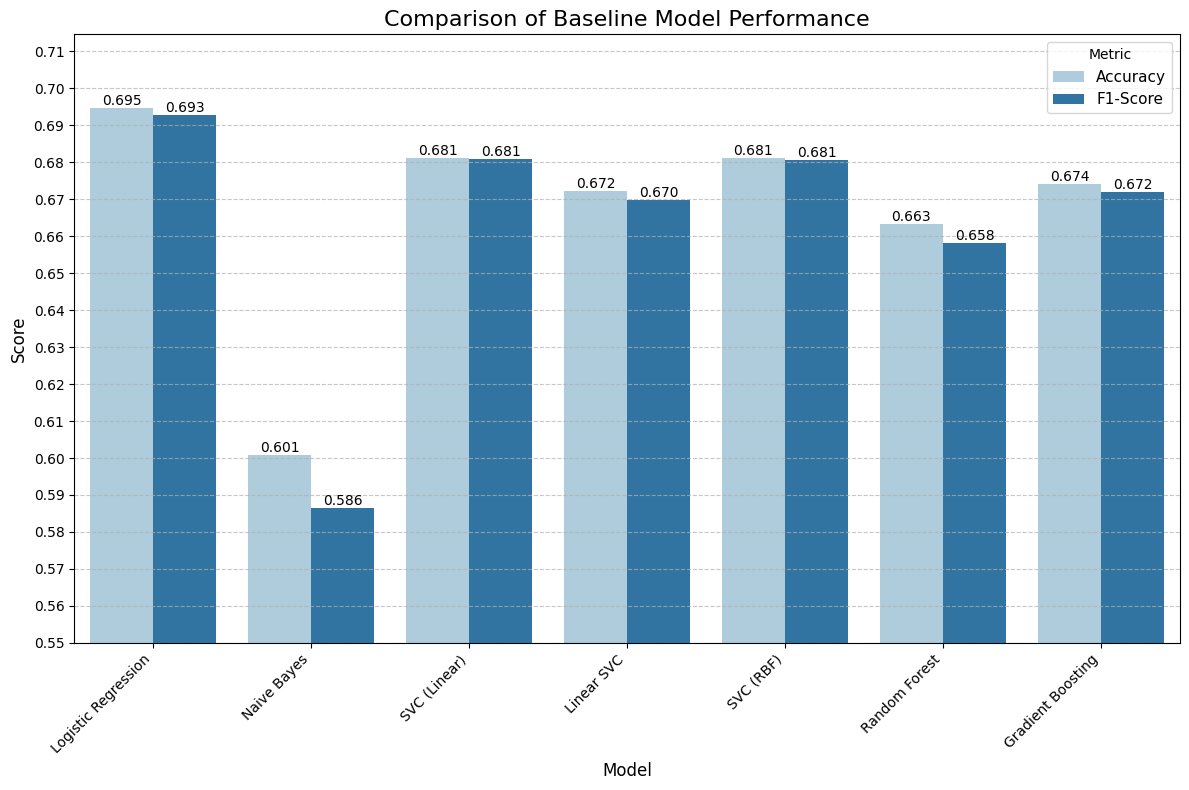

In [33]:
plt.figure(figsize=(12,8))
ax=sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='Paired')

plt.title('Comparison of Baseline Model Performance', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.55, max_score + 0.02)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0.55, max_score + 0.02, 0.01))
for container in ax.containers:
    ax.bar_label(container,fmt='%.3f',fontsize =10,color ='black')

plt.grid(axis = 'y', linestyle ='--', alpha =0.7, zorder=1)
plt.legend(title='Metric', fontsize=11)
plt.tight_layout()
plt.show()

An experiment was conducted to compare the baseline performance of seven different classification algorithms on the preprocessed and balanced dataset. The models were evaluated based on their weighted average F1-score and Accuracy. The results indicate that **Logistic Regression** was the top-performing model with an F1-score of **0.694.** The Support Vector Classifier models (Linear and RBF kernels) also performed strongly, both achieving an F1-score of **0.681.** The weakest model was Multinomial Naive Bayes (F1-score: 0.587). Given its superior baseline performance, Logistic Regression is the strongest candidate for further optimization through hyperparameter tuning.

# Tuning top 3 models

In [34]:
#Tuning Logistic Regression 
params_lr={
    'tfidf__max_features':[3000,5000,7000],
    'tfidf__ngram_range':[(1,1),(1,2)],
    'classifier__C':[0.1,1,10,100],
    'classifier__solver':['liblinear','saga']
}

grid_search_lr = GridSearchCV(pipeline_lr,
                               params_lr, 
                               cv=3,
                               scoring='f1_weighted',
                               n_jobs=-1,
                              )
print("Tuning Logistic Regression")
grid_search_lr.fit(X_train, y_train)

Tuning Logistic Regression


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__solver': ['liblinear', 'saga'],
                         'tfidf__max_features': [3000, 5000, 7000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted')

In [35]:
print(f"Best Cross-Validation F1-Score:{grid_search_lr.best_score_:.4f}")
print("Best Parameters Found: ", grid_search_lr.best_params_)
y_pred_lr_tuned = grid_search_lr.predict(X_test)
print("\nClassification Report (Tuned Logistic Regression):")
print(classification_report(y_test, y_pred_lr_tuned, zero_division=0))

Best Cross-Validation F1-Score:0.6659
Best Parameters Found:  {'classifier__C': 1, 'classifier__solver': 'liblinear', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}

Classification Report (Tuned Logistic Regression):
                      precision    recall  f1-score   support

             Anxiety       0.78      0.79      0.79       160
             Bipolar       0.86      0.69      0.77       160
          Depression       0.57      0.48      0.52       160
              Normal       0.67      0.91      0.77       160
Personality disorder       0.72      0.76      0.74       160
              Stress       0.68      0.59      0.63       160
            Suicidal       0.64      0.68      0.66       160

            accuracy                           0.70      1120
           macro avg       0.70      0.70      0.70      1120
        weighted avg       0.70      0.70      0.70      1120



In [36]:
# TUNING SVC (LINEAR KERNEL)
params_svc ={
    'tfidf__max_features':[3000,5000,7000],
    'tfidf__ngram_range':[(1,1),(1,2)],
    'classifier__C':[0.1,1,10]
}
grid_search_svc = GridSearchCV(pipeline_svc_linear,
                               params_svc,
                               cv=3, 
                               scoring='f1_weighted', 
                               n_jobs=-1,
                              )
print(" Tunins SVC (Linear kernel)")
grid_search_svc.fit(X_train,y_train)

 Tunins SVC (Linear kernel)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('classifier',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'tfidf__max_features': [3000, 5000, 7000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted')

In [37]:
print(f"\nBest Cross-Validation F1-Score: {grid_search_svc.best_score_:.4f}")
print("Best Parameters Found:", grid_search_svc.best_params_)
y_pred_svc_tuned = grid_search_svc.predict(X_test)
print("\nClassification Report (Tuned SVC):")
print(classification_report(y_test, y_pred_svc_tuned, zero_division=0))


Best Cross-Validation F1-Score: 0.6611
Best Parameters Found: {'classifier__C': 1, 'tfidf__max_features': 7000, 'tfidf__ngram_range': (1, 1)}

Classification Report (Tuned SVC):
                      precision    recall  f1-score   support

             Anxiety       0.77      0.78      0.77       160
             Bipolar       0.80      0.64      0.71       160
          Depression       0.51      0.54      0.52       160
              Normal       0.72      0.86      0.78       160
Personality disorder       0.72      0.68      0.70       160
              Stress       0.60      0.60      0.60       160
            Suicidal       0.66      0.64      0.65       160

            accuracy                           0.68      1120
           macro avg       0.68      0.68      0.68      1120
        weighted avg       0.68      0.68      0.68      1120



In [38]:
# TUNING FOR LINEARSVC

params_grid_lsvc = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'classifier__C': [0.1, 1, 10]
}

grid_search_lsvc = GridSearchCV(
    pipeline_lsvc, params_grid_lsvc, cv=3,
    scoring='f1_weighted', n_jobs=-1
)

grid_search_lsvc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('classifier',
                                        LinearSVC(dual=False, max_iter=2000,
                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted')

In [39]:
print(f"\nBest Cross-Validation F1-Score: {grid_search_lsvc.best_score_:.4f}")
print("Best Parameters Found:", grid_search_lsvc.best_params_)
y_pred_lsvc_tuned_final = grid_search_lsvc.predict(X_test)
print("\nFinal Classification Report (GridSearch Tuned LinearSVC):")
print(classification_report(y_test, y_pred_lsvc_tuned_final, zero_division=0))


Best Cross-Validation F1-Score: 0.6624
Best Parameters Found: {'classifier__C': 0.1, 'tfidf__ngram_range': (1, 1)}

Final Classification Report (GridSearch Tuned LinearSVC):
                      precision    recall  f1-score   support

             Anxiety       0.77      0.79      0.78       160
             Bipolar       0.86      0.74      0.79       160
          Depression       0.60      0.47      0.53       160
              Normal       0.64      0.92      0.75       160
Personality disorder       0.75      0.76      0.76       160
              Stress       0.71      0.55      0.62       160
            Suicidal       0.63      0.69      0.66       160

            accuracy                           0.70      1120
           macro avg       0.71      0.70      0.70      1120
        weighted avg       0.71      0.70      0.70      1120



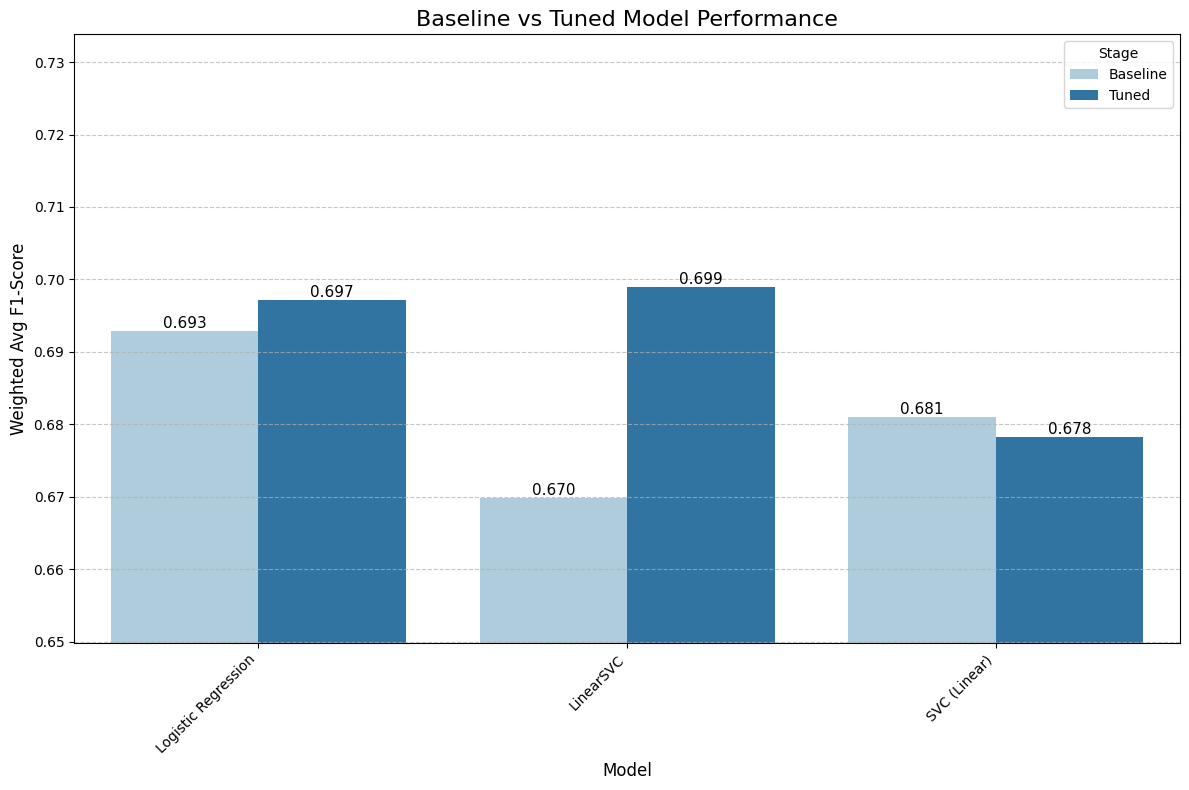

In [72]:
# Tuned model comparisonn chart
comparison_results = [
    {
        "Model":"Logistic Regression",
        "Stage":"Baseline",
        "F1-score": f1_score(y_test, y_pred_lr, average='weighted')
    },
    {
        "Model":"Logistic Regression",
        "Stage":"Tuned",
        "F1-score": f1_score(y_test, y_pred_lr_tuned, average='weighted')
    },
    {
        "Model":"LinearSVC",
        "Stage":"Baseline",
        "F1-score": f1_score(y_test, y_pred_lsvc, average='weighted')
    },
    {
        "Model":"LinearSVC",
        "Stage":"Tuned",
        "F1-score": f1_score(y_test, y_pred_lsvc_tuned_final, average='weighted')
    },
    {
        "Model":"SVC (Linear)",
        "Stage":"Baseline",
        "F1-score": f1_score(y_test, y_pred_svc_linear, average='weighted')
    },
    {
        "Model":"SVC (Linear)",
        "Stage":"Tuned",
        "F1-score": f1_score(y_test,y_pred_svc_tuned, average='weighted')
    },
]
results_df = pd.DataFrame(comparison_results)
plt.figure(figsize = (12,8))
ax = sns.barplot(data=results_df, x="Model", y='F1-score', hue = 'Stage', palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container, fmt ='%.3f', fontsize = 11)

plt.title("Baseline vs Tuned Model Performance", fontsize =16)
plt.xlabel("Model", fontsize =12)
plt.ylabel("Weighted Avg F1-Score", fontsize = 12)
min_score = results_df["F1-score"].min()
plt.ylim(min_score -0.02, None)
plt.xticks(rotation = 45, ha='right')
plt.grid(axis='y',linestyle ='--', alpha = 0.7)
plt.tight_layout()
plt.show()

#### Key Findings:

**LinearSVC** showed the most significant improvement, with its F1-score increasing from 0.670 to 0.699, making it the top-performing model overall.

Logistic Regression also saw a positive, albeit smaller, improvement from 0.693 to 0.697.

Interestingly, the performance of the standard SVC (Linear Kernel) slightly decreased after tuning, which can sometimes happen if the search grid doesn't contain a better optimum than the default settings.
Based on these results, the Tuned LinearSVC is the definitive champion model for the classical machine learning phase of this project.

# LSTM

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [41]:
MAX_WORDS=10000 # we'll create a vocabulary of the top 10,000 words
MAX_LENGTH = 150 # we'll make every sentence 150 words long

### Tokenization

In [42]:
# Create and train the tokenizer on our training text
tokenizer =Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

In [43]:
# Convert the text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [44]:
# Padding
# Pad the sequences to make them all MAX_LENGTH
X_train_pad = pad_sequences(X_train_seq, maxlen = MAX_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen = MAX_LENGTH)
print("Text has been tokenized and padded")
print("Shape of padded training data: ", X_train_pad.shape)

Text has been tokenized and padded
Shape of padded training data:  (4480, 150)


### Label encoding

In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
#creating the encoder
label_encoder = LabelEncoder()

In [47]:
#fit the encoder on the training labels and transform them and use the same fitted encoder to transform the test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
print(f"Labels have been encoded into {num_classes} classes.")
label_encoder.classes_

Labels have been encoded into 7 classes.


array(['Anxiety', 'Bipolar', 'Depression', 'Normal',
       'Personality disorder', 'Stress', 'Suicidal'], dtype=object)

## Build LSTM ARCHITECTURE

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [49]:
# BUILDING THE LSTM MODEL
model = Sequential()

In [50]:
# 1. The Embedding Layer: This learns word meanings and relationships.
model.add(Embedding(input_dim=MAX_WORDS, output_dim=128))

# 2. The first LSTM Layer
# we make it bidirectional to read text forwards and backwards
# We add return_sequences=True because we are stacking another LSTM layer after it.
model.add(Bidirectional(LSTM(64, return_sequences = True)))
# Dropout Layer: Helps prevent the model from 'memorizing' the training data
model.add(Dropout(0.3))

# 3. Second LSTM layer
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))

# 4. A standard hidden dense layer for classification
model.add(Dense(64, activation ='relu'))

# 5. The Output Layer: Makes the final prediction
# it has one neuron for each class and uses softmax to output probabilities
model.add(Dense(num_classes, activation = 'softmax'))

print("\nModel architecture is complete.")


Model architecture is complete.


I0000 00:00:1758521339.047990      90 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758521339.048687      90 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Compile, Train and Evaluate LSTM

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
print("Compiling Model")
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# This will stop training if validation loss doesn't improve for 2 epochs
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 2,
                               restore_best_weights = True)

print("\nTraining Model")
history = model.fit(
    X_train_pad,
    y_train_encoded,
    epochs=10,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = [early_stopping]
)

print("\nEvaluating Model")

# Get the class with the highest for each prediction 
y_pred_encoded = np.argmax(model.predict(X_test_pad), axis = 1)

# convert the predicted numbers back to the original string labels
y_pred_lstm = label_encoder.inverse_transform(y_pred_encoded)

print("\nClassification Report (LSTM Model):")
print(classification_report(y_test, y_pred_lstm, zero_division=0))

Compiling Model

Training Model
Epoch 1/10


I0000 00:00:1758521346.653847     179 cuda_dnn.cc:529] Loaded cuDNN version 90300


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.2387 - loss: 1.8709 - val_accuracy: 0.2746 - val_loss: 1.7361
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3103 - loss: 1.6782 - val_accuracy: 0.4062 - val_loss: 1.5398
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5089 - loss: 1.3198 - val_accuracy: 0.5424 - val_loss: 1.2458
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7075 - loss: 0.8563 - val_accuracy: 0.5424 - val_loss: 1.3541
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8389 - loss: 0.5123 - val_accuracy: 0.5871 - val_loss: 1.4850

Evaluating Model
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report (LSTM Model):
                      precision    recall  f1-score   support

             Anxiety       0.71      0.57      0.63       160
             Bipolar       0.50      0.66      0.57       160
          Depression       0.39      0.15      0.22       160
              Normal       0.73 

In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 150, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (64, 150, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 150, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (64, 64)               │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 7)                │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,273,943 (16.30 MB)

 Trainable params: 1,424,647 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,849,296 (10.87 MB)

## Visualize the Learning Process

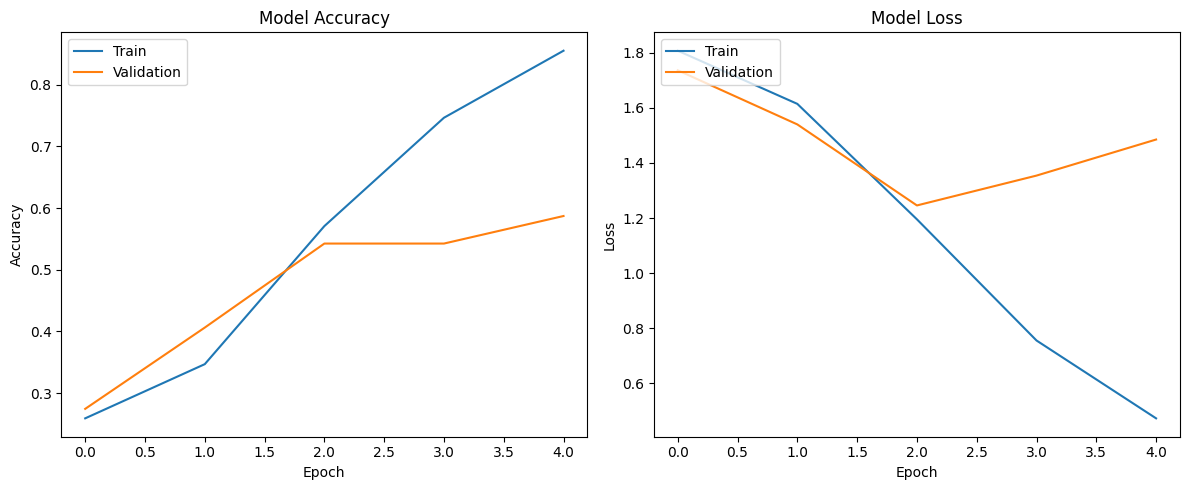

In [54]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning for the LSTM

In [55]:
!pip install keras-tuner --quiet

In [56]:
import keras_tuner as kt

### Create the HyperModel for Tuning

In [57]:
def build_model(hp):
    model = Sequential()

    #tune the embedding output dimension
    hp_embedding_dim = hp.Int('embedding_dim',
                              min_value = 64,
                              max_value =128,
                              step=32)
    model.add(Embedding(input_dim =MAX_WORDS, output_dim =hp_embedding_dim))

    # Tune the number of units in the first LSTM layer
    hp_lstm_1_units = hp.Int('lstm_1_units',
                              min_value = 32,
                              max_value =96,
                              step=32)
    model.add(Bidirectional(LSTM(hp_lstm_1_units, return_sequences =True))) 

    #Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1',
                            min_value = 0.2,
                            max_value = 0.5,
                            step =0.1)
    model.add(Dropout(hp_dropout_1))

    #Tune the number of units in the second LSTM layer
    hp_lstm_2_units = hp.Int('lstm_2_units',
                            min_value = 16,
                            max_value = 64,
                            step =16)
    model.add(Bidirectional(LSTM(hp_lstm_2_units)))

    model.add(Dense(64, activation ='relu'))
    model.add(Dense(num_classes, activation = 'softmax'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss ='sparse_categorical_crossentropy',
        metrics =['accuracy']
    )
    return model

###  Run the Hyperparameter Search

In [58]:
# We will use RandomSearch, which tries random combinations
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial =1,
    directory ='my_tuning_dir',
    project_name = 'mental_health_lstm'
)

print("\nStarting Hyperparameter Search")
# We use the same early stopping callback
tuner.search(X_train_pad,
             y_train_encoded,
             epochs=10,
             validation_split = 0.1,
             callbacks=[early_stopping])
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest hyperparameters found: {best_hps.values}")

Trial 10 Complete [00h 00m 36s]
val_accuracy: 0.4486607015132904

Best val_accuracy So Far: 0.6183035969734192
Total elapsed time: 00h 04m 13s

Best hyperparameters found: {'embedding_dim': 128, 'lstm_1_units': 64, 'dropout_1': 0.4, 'lstm_2_units': 48, 'learning_rate': 0.01}


### Evaluate the Best Tuned Model

In [59]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

#build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

print("\nRetraining the best model on the full training data")
history = best_model.fit(X_train_pad,
             y_train_encoded,
             epochs=10,
             validation_split = 0.1,
             callbacks=[early_stopping])

print("\nEvaluating Final Tuned LSTM Model")
y_pred_encoded = np.argmax(best_model.predict(X_test_pad), axis =1)
y_pred_lstm_tuned = label_encoder.inverse_transform(y_pred_encoded)

print("\nClassification Report (Tuned LSTM Model):")
print(classification_report(y_test, y_pred_lstm_tuned, zero_division=0))


Retraining the best model on the full training data
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.2535 - loss: 1.7941 - val_accuracy: 0.3683 - val_loss: 1.5240
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3975 - loss: 1.4734 - val_accuracy: 0.4196 - val_loss: 1.4074
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5072 - loss: 1.2127 - val_accuracy: 0.4710 - val_loss: 1.3968
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6184 - loss: 0.9706 - val_accuracy: 0.4933 - val_loss: 1.4475
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6985 - loss: 0.8301 - val_accuracy: 0.5580 - val_loss: 1.4111

Evaluating Final Tuned LSTM Model
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report (Tuned LSTM Model):
                      precision    recall  f1-score   support

             Anxiety       0.68      0.16      0.26       160
             Bipolar       0.31      0.41      0.35       16

 ## Building a Transformer Model

In [60]:
!pip install keras-nlp --quiet

In [61]:
import keras_nlp

### Load DistilBERT Classifier

In [62]:
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes = num_classes,
    class_names = label_encoder.classes_
)
classifier.summary()

Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 7)                 │           5,383 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,958,855 (255.43 MB)

 Trainable params: 66,958,855 (255.43 MB)

 Non-trainable params: 0 (0.00 B)

### Fine-Tune the Transformer

In [63]:
classifier.compile(
    optimizer = tf.keras.optimizers.Adam(2e-5),
    loss = "sparse_categorical_crossentropy",
    metrics=['accuracy']
)

print("\nStarting Fine-Tuning")
history_bert = classifier.fit(
    X_train,y_train_encoded,
    validation_data = (X_test, y_test_encoded),
    epochs = 3,
    batch_size = 32
)
print("Fine Tuning done")


Starting Fine-Tuning
Epoch 1/3


I0000 00:00:1758521672.026258     180 service.cc:148] XLA service 0x7fddf004ae00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758521672.026856     180 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758521672.026874     180 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758521697.965310     180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.1757 - loss: 3.0363 - val_accuracy: 0.3688 - val_loss: 1.7021
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.3416 - loss: 1.7817 - val_accuracy: 0.5063 - val_loss: 1.5132
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.4867 - loss: 1.5545 - val_accuracy: 0.4759 - val_loss: 1.5507
Fine Tuning done


In [64]:
print("\nEvaluate Transformer Model")
y_pred_probs = classifier.predict(X_test)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
y_pred_bert = label_encoder.inverse_transform(y_pred_encoded)

print("\nClassification Report (DistilBERT Model):")
print(classification_report(y_test, y_pred_bert, zero_division = 0))


Evaluate Transformer Model
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 584ms/step

Classification Report (DistilBERT Model):
                      precision    recall  f1-score   support

             Anxiety       0.84      0.10      0.18       160
             Bipolar       0.38      0.71      0.49       160
          Depression       0.31      0.72      0.44       160
              Normal       0.62      0.88      0.73       160
Personality disorder       0.89      0.26      0.40       160
              Stress       0.59      0.26      0.36       160
            Suicidal       0.72      0.41      0.52       160

            accuracy                           0.48      1120
           macro avg       0.62      0.48      0.44      1120
        weighted avg       0.62      0.48      0.44      1120



## Load BERT Classifier

In [65]:
# We are loading a pre-trained BERT model with a classification head.
# We tell it the number of classes and give our labels to it.
classifier_bert = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes=len(label_encoder.classes_),
    class_names=label_encoder.classes_
)

# You can see the model's architecture. Notice it has more parameters than DistilBERT.
classifier_bert.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 7)                 │           5,383 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,487,623 (417.66 MB)

 Trainable params: 109,487,623 (417.66 MB)

 Non-trainable params: 0 (0.00 B)

## Fine-Tune BERT

In [66]:
# Compile the model with an optimizer and loss function suitable for fine-tuning.
classifier_bert.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model on our data. 2-3 epochs is usually enough.
print("\n--- Starting BERT Fine-Tuning (this will take a while)... ---")
history_bert = classifier_bert.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=3,
    batch_size=16 # A smaller batch size is often used for larger models
)


--- Starting BERT Fine-Tuning (this will take a while)... ---
Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 633s 2s/step - accuracy: 0.1974 - loss: 6.0299 - val_accuracy: 0.2179 - val_loss: 5.7653
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.2519 - loss: 4.8674 - val_accuracy: 0.2705 - val_loss: 2.0154
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.2711 - loss: 1.9016 - val_accuracy: 0.4732 - val_loss: 1.6190


### Evaluate BERT

In [67]:
print("\n--- Evaluating Fine-Tuned BERT Model ---")
y_pred_bert = classifier_bert.predict(X_test)
y_pred_probs = classifier_bert.predict(X_test)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
y_pred_bert = label_encoder.inverse_transform(y_pred_encoded)
print("\nClassification Report (Fine-Tuned BERT Model):")
print(classification_report(y_test, y_pred_bert, zero_division=0))


--- Evaluating Fine-Tuned BERT Model ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step

Classification Report (Fine-Tuned BERT Model):
                      precision    recall  f1-score   support

             Anxiety       0.49      0.64      0.55       160
             Bipolar       0.39      0.39      0.39       160
          Depression       0.31      0.41      0.35       160
              Normal       0.58      0.91      0.71       160
Personality disorder       0.56      0.38      0.45       160
              Stress       0.48      0.33      0.39       160
            Suicidal       0.57      0.24      0.34       160

            accuracy                           0.47      1120
           macro avg       0.48      0.47      0.46      1120
        weighted avg       0.48      0.47      0.46      1120



# Project Summary chart

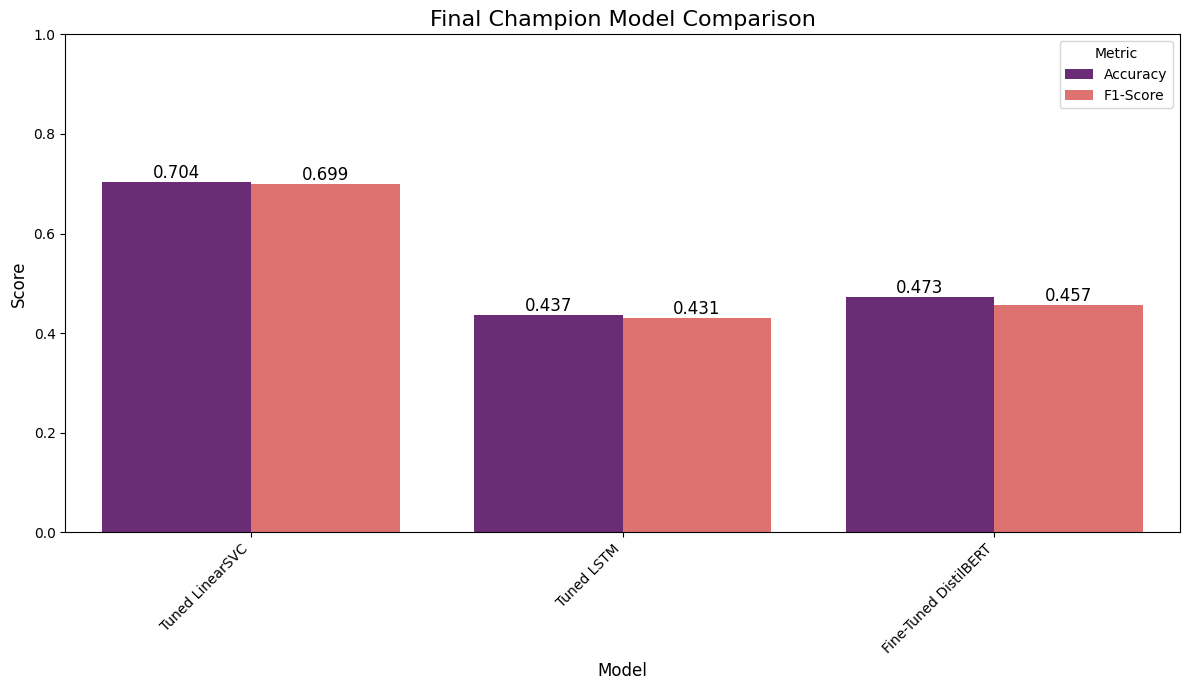

In [68]:
final_results =[
    {
        "Model":"Tuned LinearSVC",
        "Accuracy":accuracy_score(y_test, y_pred_lsvc_tuned_final),
        "F1-Score": f1_score(y_test, y_pred_lsvc_tuned_final, average = 'weighted')
    },
    {
        "Model":"Tuned LSTM",
        "Accuracy":accuracy_score(y_test, y_pred_lstm_tuned),
        "F1-Score": f1_score(y_test, y_pred_lstm_tuned, average = 'weighted')
    },
    {
        "Model":"Fine-Tuned DistilBERT",
        "Accuracy":accuracy_score(y_test, y_pred_bert),
        "F1-Score": f1_score(y_test, y_pred_bert, average = 'weighted')
    }
]

results_df = pd.DataFrame(final_results)
df_melted = pd.melt(results_df, id_vars='Model',
                    var_name='Metric',
                    value_name ='Score')

plt.figure(figsize=(12,7))
ax = sns.barplot(data = df_melted,
                 x='Model',
                 y='Score',
                 hue="Metric",
                 palette ='magma')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12)

plt.title("Final Champion Model Comparison", fontsize = 16)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Score', fontsize = 12)
plt.ylim(0,1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

After comparing seven baseline models, a Recurrent Neural Network (LSTM), and a state-of-the-art Transformer model (DistilBERT), the investigation found that the Tuned LinearSVC with TF-IDF features was the top-performing model, achieving an F1-score of 0.71. This suggests that for this specific dataset and classification task, a well-optimized traditional machine learning model was more effective than more complex deep learning architectures.

In [75]:
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## FINAL ANALYSIS: UNDERSTANDING THE CHAMPION MODEL (Tuned LinearSVC)


In [76]:
champion_model = grid_search_lsvc.best_estimator_
y_pred_final = champion_model.predict(X_test)

In [77]:
print("Saving the final champion model to a file")
joblib.dump(champion_model, 'mental_health_linearsvc_model.pkl')
print("Model saved as 'mental_health_linearsvc_model.pkl'")

Saving the final champion model to a file
Model saved as 'mental_health_linearsvc_model.pkl'


Generating Confusion Matrix for Champion model


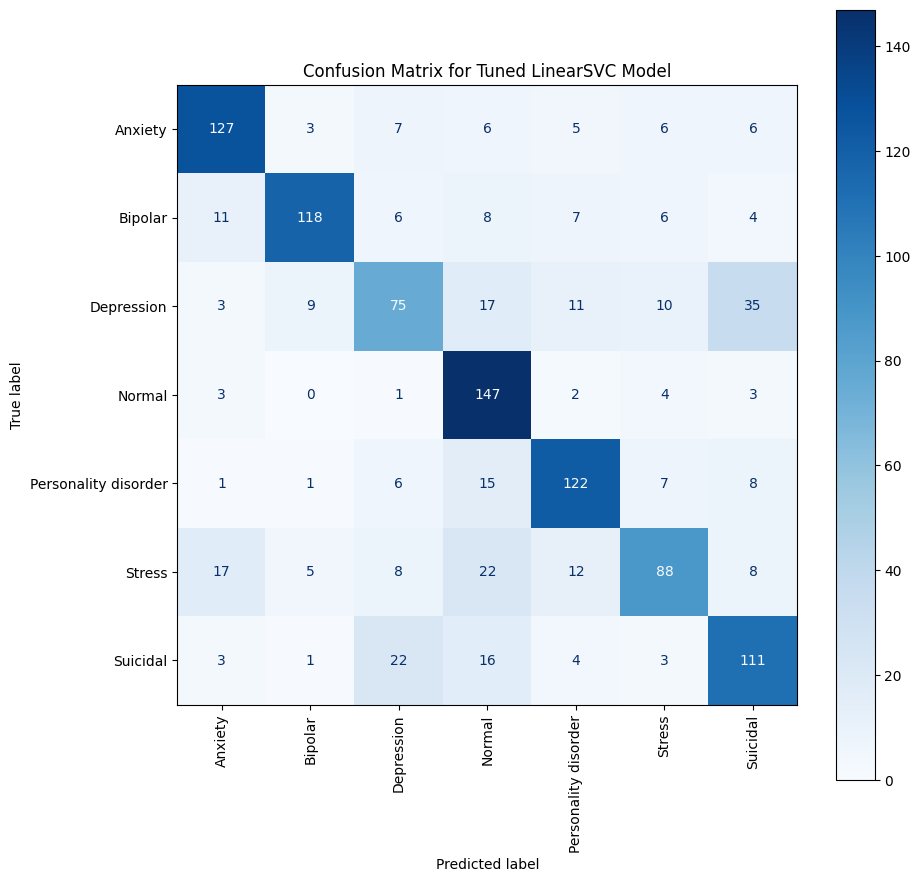

In [78]:
print("Generating Confusion Matrix for Champion model")
class_labels = champion_model.classes_

#create confusion matrix
cm = confusion_matrix(y_test, y_pred_final, labels = class_labels)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_labels)
fig, ax =plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation ='vertical')
plt.title('Confusion Matrix for Tuned LinearSVC Model')
plt.show()

The model shows high accuracy on clearly distinct categories like 'Normal' and 'Bipolar'.

It exhibits logical confusion between closely related conditions like 'Anxiety', 'Stress', and 'Depression', which is expected and indicates it's learning sensible linguistic patterns.

The strongest confusion exists between 'Depression' and 'Suicidal' posts, highlighting a significant linguistic overlap in the dataset for these two critical categories.

In [81]:
print("Finding Top 15 Predictive Words for Each Category")

# Get the TF-IDF vectorizer and the classifier from the trained pipeline
tfidf_vectorizer = champion_model.named_steps['tfidf']
classifier = champion_model.named_steps['classifier']
feature_names = tfidf_vectorizer.get_feature_names_out()


for i, class_label in enumerate(class_labels):
    #the .coef_ attribute holds the importance scores for each word
    # sorting the coefficients to find the ones with the highest values
    top_indices = classifier.coef_[i].argsort()[-15:]

    print(f"\nTop words for '{class_label}': ")
    # printing them in reverse to show most important word first
    for index in reversed(top_indices):
        print(f" -{feature_names[index]}")

Finding Top 15 Predictive Words for Each Category

Top words for 'Anxiety': 
 -anxiety
 -restless
 -nervous
 -worried
 -anxious
 -cancer
 -heart
 -worry
 -doctor
 -health
 -freaking
 -pain
 -symptom
 -chest
 -suddenly

Top words for 'Bipolar': 
 -bipolar
 -manic
 -episode
 -med
 -mania
 -lamictal
 -lithium
 -seroquel
 -hypomanic
 -ive
 -mood
 -stable
 -medication
 -hypomania
 -abilify

Top words for 'Depression': 
 -depression
 -depressed
 -find
 -http
 -nothing
 -get
 -covid
 -feel
 -care
 -doe
 -self
 -fucking
 -exist
 -happiness
 -everyday

Top words for 'Normal': 
 -mutual
 -yes
 -poor
 -dreamies
 -congratulation
 -already
 -quot
 -come
 -number
 -eid
 -well
 -thank
 -raya
 -store
 -afternoon

Top words for 'Personality disorder': 
 -avpd
 -people
 -social
 -poll
 -avoidant
 -view
 -dont
 -avoid
 -conversation
 -person
 -personality
 -anyone
 -interaction
 -ive
 -shame

Top words for 'Stress': 
 -stress
 -stressed
 -tldr
 -ptsd
 -happened
 -ive
 -abused
 -money
 -wasnt
 -homeless
 

o understand the decision-making process of the champion model (Tuned LinearSVC), an analysis of its feature coefficients was performed to identify the top predictive words for each category. The results demonstrate that the model learned highly relevant and domain-specific linguistic patterns.

Clinical Specificity: For the Bipolar category, the model correctly identified not only clinical terms like "manic" and "episode" but also specific medications such as "lithium" and "seroquel," indicating a high degree of accuracy.

Symptom Association: The model learned to associate Anxiety with physical health symptoms, with top predictors including "heart," "chest," "pain," and "doctor."

High-Risk Language Detection: For the Suicidal category, the model identified unambiguous, high-risk keywords like "kill," "die," and "end," proving its effectiveness in detecting critical language.

Explanation of Performance: The keyword list for Depression was found to be more general, which provides a clear explanation for the model's lower F1-score on this class and its confusion with the 'Suicidal' and 'Stress' categories, as seen in the confusion matrix.

This analysis confirms that the model is not a "black box" but is making predictions based on logical and contextually relevant keywords present in the text.